# Setting up the data

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

text = open(dataset_file_path, mode='r').read()
vocab = sorted(set(text))
char2index = {char: index for index, char in enumerate(vocab)}
index2char = np.array(vocab)
text_as_int = np.array([char2index[char] for char in text])
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)


In [7]:
## Setting up word2vec
from copy import deepcopy as copy
import string
import re
import gensim


word_split = text.replace('\n',' \n ')
word_split = word_split.translate(str.maketrans('', '', string.punctuation))

word_split = word_split.lower()
word_split = word_split.split(' ')
worded_text = copy(word_split)
word_split.sort()

unique_words = []
word_to_ind = {}
i = 0
for word in word_split:
  if word not in unique_words:
    unique_words.append(word)
    word_to_ind[word] = i
    i +=1

def text_to_ind(text, word_to_ind):
  out_text = []
  i = max(word_to_ind.values())
  for word in text:
    if word not in word_to_ind.keys():
      word_to_ind[word] = i
      i += 1
    out_text.append(word_to_ind[word])
  
  return out_text

text_ind = text_to_ind(text, word_to_ind)
word_vocab = np.array(unique_words)
word2index ={word: index for index, word in enumerate(word_vocab)}

index2word = np.array(word_vocab)

text_as_wordints = np.array([word2index[word] for word in worded_text])

print("# words: {}, # unique: {}, length word_vocab: {}".format(len(word_split),len(unique_words), len(word_vocab)))
print('{')
for word, _ in zip(word2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(word), word2index[word]))
print('  ...\n}')
print("first ten words in words ---> first ten words as ints")
print("{} ---> {}".format(repr(worded_text[:10]), repr(text_as_wordints[:10])))

for i in range(6):
  print(index2word[text_as_wordints[(i)]])

# words: 249893, # unique: 12850, length word_vocab: 12850
{
  ''  :   0,
  '\n':   1,
  '3' :   2,
  'a' :   3,
  'abandond':   4,
  'abase':   5,
  'abate':   6,
  'abated':   7,
  'abbey':   8,
  'abbot':   9,
  'abed':  10,
  'abels':  11,
  'abet':  12,
  'abhor':  13,
  'abhorrd':  14,
  'abhorred':  15,
  'abhorring':  16,
  'abhors':  17,
  'abhorson':  18,
  'abide':  19,
  ...
}
first ten words in words ---> first ten words as ints
['first', 'citizen', '\n', 'before', 'we', 'proceed', 'any', 'further', 'hear', 'me'] ---> array([ 4178,  1955,     1,   938, 12341,  8515,   462,  4574,  5172,
        6832])
first
citizen


before
we
proceed


In [8]:
#for line in open(dataset_file_path, mode='r').readlines():
#  print(line)

In [9]:
# Setting up dataset


def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text


BATCH_SIZE = 64
BUFFER_SIZE = 10000


# char dataset
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)
char_dataset = sequences.map(split_input_target)
char_dataset = char_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# word dataset
word_dataset = tf.data.Dataset.from_tensor_slices(text_as_wordints)
word_sequences = word_dataset.batch(sequence_length + 1, drop_remainder=True)
word_dataset = word_sequences.map(split_input_target)
word_dataset = word_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)



In [10]:
def perplexity(labels, logits):
    cross_entropy = tf.losses.sparse_categorical_crossentropy(
        y_true=labels,
        y_pred=logits,
        from_logits=True
        )
    perplexity = tf.exp(tf.reduce_mean(cross_entropy))
    return perplexity

In [11]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#model.compile(
#    optimizer=adam_optimizer,
#    loss=loss
#    metrics=[perplexity]
#)

# Initializing the models

In [12]:
# Choose if char or word2vec
w2v = 1

# Length of the vocabulary and selection of dataset.
if w2v:
  vocab_size = len(word_vocab)
  dataset = word_dataset
  embedding_dim = 100
else:
  vocab_size = len(vocab)
  dataset = char_dataset
  embedding_dim = 256

# The embedding dimension.


# Number of RNN units.
#rnn_units = 59
rnn_units = 500
def build_model_RNN(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
        ))

    model.add(tf.keras.layers.SimpleRNN(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model
model_RNN = build_model_RNN(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)
model_RNN.compile(loss=loss, optimizer=adam_optimizer, metrics=[perplexity])
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 100)           1285000   
                                                                 
 simple_rnn (SimpleRNN)      (64, None, 500)           300500    
                                                                 
 dense (Dense)               (64, None, 12850)         6437850   
                                                                 
Total params: 8,023,350
Trainable params: 8,023,350
Non-trainable params: 0
_________________________________________________________________


In [13]:
def build_model_LSTM1(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
        ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model
model_LSTM1 = build_model_LSTM1(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)
model_LSTM1.compile(loss=loss, optimizer=adam_optimizer, metrics=[perplexity])
model_LSTM1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 100)           1285000   
                                                                 
 lstm (LSTM)                 (64, None, 500)           1202000   
                                                                 
 dense_1 (Dense)             (64, None, 12850)         6437850   
                                                                 
Total params: 8,924,850
Trainable params: 8,924,850
Non-trainable params: 0
_________________________________________________________________


In [14]:
def build_model_LSTM2(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))
    
    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model
model_LSTM2 = build_model_LSTM2(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)
model_LSTM2.compile(loss=loss, optimizer=adam_optimizer, metrics=[perplexity])
model_LSTM2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (64, None, 100)           1285000   
                                                                 
 lstm_1 (LSTM)               (64, None, 500)           1202000   
                                                                 
 lstm_2 (LSTM)               (64, None, 500)           2002000   
                                                                 
 dense_2 (Dense)             (64, None, 12850)         6437850   
                                                                 
Total params: 10,926,850
Trainable params: 10,926,850
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Directory where the checkpoints will be saved.
checkpoint_dir_RNN = 'tmp/checkpoints/RNN'
os.makedirs(checkpoint_dir_RNN, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix_RNN = os.path.join(checkpoint_dir_RNN, 'ckpt_{epoch}')

checkpoint_callback_RNN=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix_RNN,
    save_weights_only=True
)

checkpoint_dir_LSTM1 = 'tmp/checkpoints/LSTM1'
os.makedirs(checkpoint_dir_LSTM1, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix_LSTM1 = os.path.join(checkpoint_dir_LSTM1, 'ckpt_{epoch}')

checkpoint_callback_LSTM1=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix_LSTM1,
    save_weights_only=True
)

checkpoint_dir_LSTM2 = 'tmp/checkpoints/LSTM2'
os.makedirs(checkpoint_dir_LSTM2, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix_LSTM2 = os.path.join(checkpoint_dir_LSTM2, 'ckpt_{epoch}')

checkpoint_callback_LSTM2=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix_LSTM2,
    save_weights_only=True
)

In [16]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [17]:
callback_RNN = LossHistory()
callback_LSTM1 = LossHistory()
callback_LSTM2 = LossHistory()

# Training

In [18]:
EPOCHS=4

In [19]:
history_RNN = model_RNN.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback_RNN
  ]
)

Epoch 1/4
38/38 [==============================] - 249s 7s/step - loss: 6.7513 - perplexity: 1831.6752
Epoch 2/4
38/38 [==============================] - 244s 6s/step - loss: 6.1423 - perplexity: 465.8359
Epoch 3/4
38/38 [==============================] - 244s 6s/step - loss: 6.1358 - perplexity: 462.6686
Epoch 4/4
38/38 [==============================] - 246s 6s/step - loss: 6.1361 - perplexity: 462.7906


In [20]:
history_LSTM1 = model_LSTM1.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback_LSTM1
  ]
)

Epoch 1/4
38/38 [==============================] - 298s 8s/step - loss: 6.9128 - perplexity: 2007.0409
Epoch 2/4
38/38 [==============================] - 368s 10s/step - loss: 6.2174 - perplexity: 502.2813
Epoch 3/4
38/38 [==============================] - 318s 8s/step - loss: 6.1723 - perplexity: 480.1109
Epoch 4/4
38/38 [==============================] - 291s 8s/step - loss: 6.1590 - perplexity: 473.5790


In [21]:
history_LSTM2 = model_LSTM2.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback_LSTM2
  ]
)

Epoch 1/4
38/38 [==============================] - 391s 10s/step - loss: 6.8964 - perplexity: 1742.2172
Epoch 2/4
38/38 [==============================] - 383s 10s/step - loss: 6.2583 - perplexity: 522.8821
Epoch 3/4
38/38 [==============================] - 386s 10s/step - loss: 6.2027 - perplexity: 494.8096
Epoch 4/4
38/38 [==============================] - 383s 10s/step - loss: 6.1832 - perplexity: 485.0641


# Evaluating training

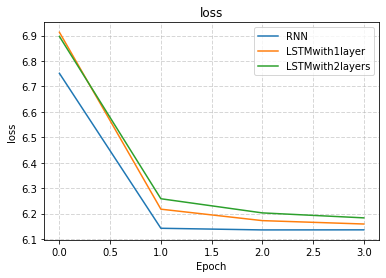

In [22]:
loss_RNN = history_RNN.history['loss']
loss_LSTM1 = history_LSTM1.history['loss']
loss_LSTM2 = history_LSTM2.history['loss']
plt.title('loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.plot(loss_RNN, label='RNN')
plt.plot(loss_LSTM1, label='LSTMwith1layer')
plt.plot(loss_LSTM2, label='LSTMwith2layers')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

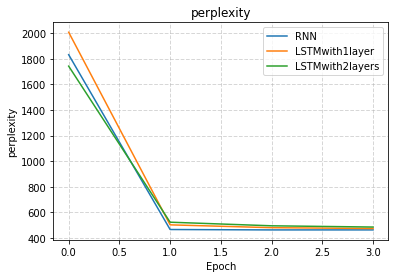

In [23]:
perplexity_RNN = history_RNN.history['perplexity']
perplexity_LSTM1 = history_LSTM1.history['perplexity']
perplexity_LSTM2 = history_LSTM2.history['perplexity']
plt.title('perplexity')
plt.xlabel('Epoch')
plt.ylabel('perplexity')
plt.plot(perplexity_RNN, label='RNN')
plt.plot(perplexity_LSTM1, label='LSTMwith1layer')
plt.plot(perplexity_LSTM2, label='LSTMwith2layers')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

In [24]:
tf.train.latest_checkpoint(checkpoint_dir_RNN)
simplified_batch_size = 1

model_RNN = build_model_RNN(vocab_size, embedding_dim, rnn_units, batch_size=1)

model_RNN.load_weights(tf.train.latest_checkpoint(checkpoint_dir_RNN))

model_RNN.build(tf.TensorShape([simplified_batch_size, None]))
model_RNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (1, None, 100)            1285000   
                                                                 
 simple_rnn_1 (SimpleRNN)    (1, None, 500)            300500    
                                                                 
 dense_3 (Dense)             (1, None, 12850)          6437850   
                                                                 
Total params: 8,023,350
Trainable params: 8,023,350
Non-trainable params: 0
_________________________________________________________________


In [25]:
tf.train.latest_checkpoint(checkpoint_dir_LSTM1)
simplified_batch_size = 1

model_LSTM1 = build_model_LSTM1(vocab_size, embedding_dim, rnn_units, batch_size=1)

model_LSTM1.load_weights(tf.train.latest_checkpoint(checkpoint_dir_LSTM1))

model_LSTM1.build(tf.TensorShape([simplified_batch_size, None]))
model_LSTM1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (1, None, 100)            1285000   
                                                                 
 lstm_3 (LSTM)               (1, None, 500)            1202000   
                                                                 
 dense_4 (Dense)             (1, None, 12850)          6437850   
                                                                 
Total params: 8,924,850
Trainable params: 8,924,850
Non-trainable params: 0
_________________________________________________________________


In [26]:
tf.train.latest_checkpoint(checkpoint_dir_LSTM2)
simplified_batch_size = 1

model_LSTM2 = build_model_LSTM1(vocab_size, embedding_dim, rnn_units, batch_size=1)

model_LSTM2.load_weights(tf.train.latest_checkpoint(checkpoint_dir_LSTM2))

model_LSTM2.build(tf.TensorShape([simplified_batch_size, None]))
model_LSTM2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (1, None, 100)            1285000   
                                                                 
 lstm_4 (LSTM)               (1, None, 500)            1202000   
                                                                 
 dense_5 (Dense)             (1, None, 12850)          6437850   
                                                                 
Total params: 8,924,850
Trainable params: 8,924,850
Non-trainable params: 0
_________________________________________________________________


# Generating text

In [41]:
def generate_text(model, start_string, num_generate = 1000, temperature=1.0, w2v=0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    if w2v:
      input_indices = [word2index[start_string]]
    else:
      input_indices = [char2index[s] for s in start_string]

    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        if w2v:
          text_generated.append(index2word[predicted_id]+ ' ')
        else:
          text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [43]:
def topPSampling(p,logits):
  sortedLogits = tf.sort(logits,direction='DESCENDING')
  print(sortedLogits)
  sortedProbs = tf.nn.softmax(sortedLogits)

  probsSum = tf.cumsum(sortedProbs, axis=1, exclusive=True)
  maskedLogits = tf.where(probsSum < p, sortedLogits, tf.ones_like(sortedLogits)*1000)  
  minLogits= tf.reduce_min(maskedLogits, axis=1, keepdims=True)  
  return tf.where(
      logits < minLogits,
      tf.ones_like(logits, dtype=logits.dtype) * -1e10,
      logits,
      )
  
def generate_text_with_NucleusSampling(model, start_string, num_generate = 1000, temperature=0.5, w2v = 0):
    if w2v:
      input_indices = [word2index[start_string]]
    else:
      input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)
    text_generated = []
    model.reset_states()
    out_text=start_string
    for char_index in range(num_generate):
      predictions = model(input_indices)
      predictions = tf.squeeze(predictions, 0)
      
      predictionsNew = topPSampling(0.95,predictions)
      actualPrediction = tf.random.categorical(predictionsNew, num_samples=1)[-1,0].numpy()


      #passing the prediction back to the model
      input_indices = tf.expand_dims([actualPrediction], 0)
      if w2v:
        text_generated.append(index2word[actualPrediction])
      else:
        text_generated.append(index2char[actualPrediction])
    return (start_string + ' '.join(text_generated))

In [42]:

if w2v:
  print(generate_text(model_LSTM1, start_string="romeo", w2v=w2v))
else:
  print(generate_text(model_LSTM1, start_string=u"ROMEO: "))

romeobeastly flow sucking and been claudios say hellgovernd together none help is talk tybalt hundred me three die weep pearl to  in art the here love and true 
 senator gratis usurps better 
 
 blood him next entreat 
 and at days neck him 
 
 with and will treasury  
 in warwick our a and  youll a of  too these knock candles scarce 
 lingering it my a slew sends need  me content now the by 
 his widow me 
 the  and lordship bolingbroke you how had the writes and whose to merry countrys froth safe 
 ratcliff princess this am weddingbed  
 even  hearing a as no sir signior 
 neighbours too as all 
 
 whoreson 
 
 cominius discontented 
 while 
 
 
 do 
 call both 
 but more lives miscarry soldier we to all to full 
  town coming 
 a action you is 
 beat hard  toil but still he understanding yielded lord head give why at myself gremio 
 think of though  a your as our 
 authority it true  richards duke we we shake 
 them 
 a come unexamined favourable 
 of beauteous staff of is second gr

In [44]:
if w2v:
  print(generate_text_with_NucleusSampling(model_LSTM1, start_string="romeo", w2v = w2v))
else:
  print(generate_text_with_NucleusSampling(model_LSTM1, start_string=u"ROMEO: "))

tf.Tensor(
[[ 0.10427668  0.08117614  0.08003682 ... -0.16251172 -0.16287154
  -0.16511378]], shape=(1, 12850), dtype=float32)
tf.Tensor(
[[ 0.29394147  0.22877425  0.22636454 ... -0.49866754 -0.4990534
  -0.5017174 ]], shape=(1, 12850), dtype=float32)
tf.Tensor(
[[ 1.030691    0.78482896  0.7796942  ... -1.7691156  -1.770741
  -1.7720225 ]], shape=(1, 12850), dtype=float32)
tf.Tensor([[ 3.8414578  2.84233    2.840953  ... -6.381066  -6.397365  -6.411089 ]], shape=(1, 12850), dtype=float32)
tf.Tensor([[  6.330139   4.680189   4.670533 ... -10.45404  -10.498301 -10.521844]], shape=(1, 12850), dtype=float32)
tf.Tensor(
[[  6.6428285   4.918116    4.9111004 ... -10.987913  -11.036974
  -11.058784 ]], shape=(1, 12850), dtype=float32)
tf.Tensor(
[[  6.683863    4.9486246   4.941331  ... -11.05713   -11.106196
  -11.127975 ]], shape=(1, 12850), dtype=float32)
tf.Tensor(
[[  6.6890435   4.9527774   4.945893  ... -11.066079  -11.1153
  -11.13724  ]], shape=(1, 12850), dtype=float32)
tf.Tensor(

#2

In [45]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text_beam(model, start_string, num_generate = 100, n_beam = 2, w2v=0):
    
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    if w2v:
      input_indices = [word2index[start_string]]
    else:
      input_indices = [char2index[s] for s in start_string]
    input_b = []
    for i in range(n_beam):
      input_b = input_b + [input_indices]


    # Empty string to store our results.
    text_generated = []
    gs = []
    # Here batch size == 1.
    model.reset_states()
    
    predictions = model.predict(tf.expand_dims(input_indices, 0))
    predictions = tf.squeeze(predictions, 0)
    p = predictions[predictions.shape[0]-1]
    id = np.zeros(n_beam)
    for i in range(n_beam):
      id[i] = np.argsort(p)[-1-i]
      gs = gs + [text_generated + list(index2char[int(id[i])])]
      input_b[i] = input_b[i] + [id[i]]
    for char_index in range(num_generate-2):
        #for i in range(n_beam):
        #  print(id[i])
        #print("----------------------------")
        p = np.array([])
        id = np.zeros(n_beam)
        for i in range(n_beam):
          model.reset_states()
          predictions = model.predict(tf.expand_dims(input_b[i], 0))                                              
          # remove the batch dimension
          predictions = tf.squeeze(predictions, 0)
          p = np.append(p, predictions[predictions.shape[0]-1])
        for i in range(n_beam):
          id[i] = np.argsort(p)[-1-i]
        gs_t = copy.deepcopy(gs)
        input_b_t = copy.deepcopy(input_b)
        for i in range(n_beam):
          a = int(id[0] / 65)
          b = int(id[0] % 65)
          gs[i] = gs_t[a] + list(index2char[b])
          input_b[i] = input_b_t[a] + [b]
    p = np.array([])
    for i in range(n_beam):
      model.reset_states()
      predictions = model.predict(tf.expand_dims(input_b[0], 0))                                              
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      p = np.append(p, predictions[predictions.shape[0]-1])

    id = np.argsort(p)[-1]
    a = int(id / 65)
    b = int(id % 65)
    if w2v:
      text_generated = gs[a] + [index2word[b]] + " "
    else:
      text_generated = gs[a] + [index2char[b]]
    return (start_string + ''.join(text_generated))

In [46]:
if w2v:
  print(generate_text(model_LSTM1, start_string = "romeo", w2v=w2v))
else:
  print(generate_text_beam(model_LSTM1, start_string=u"ROMEO: "))

romeobrands infancy agues demigod he are 
 thou 
 crave womb livest 
 big as when now i is i thine go of nurse my 
 
 strength 
 i dido lord lady field see 
 and say and lord anointed the provost this is how news  
 
 best 
 was feel sicinius were  can and shall corn king noise when 
 to this such soldier heart a mariana dead and  as what servingman noble the our edward supper bring will his he 
 for 
 castle thee sort it hours less for 
 company good i well that hear proud as no belike 
 to my son mother of for much it honour   are 
 
 our  king gone 
 paris the wealthy 
 talkers  you think weakness this go worm bring  sir enough gentry will the birth and mayor bring 
 city come learned and upon imagined captain that a and 
 my more i not me 
 which yet but thy ill like 
 this continue stir will the come purse a cease i that mind thou juliet and to am so advantage it clerk grace i eat to glad there gods me of flower abused 
 sir us out dissentious it entreat  sweet 
 out am men affabl